In [1]:
"""
Grid preparation for future aspen project:

Future:
    - Future aspen suitability
    - Future fire probability

Contemporary:
    - ca. 2019 Aspen canopy cover
    - combustible mass of the built environment
    - burn probability and conditional flame length probability
    - ca. 2016 USFS TreeMap summaries (potential aspen understory, etc)

Author: maxwell.cook@colorado.edu
"""

import os, sys, time, re
import pandas as pd
import xarray as xr
import geopandas as gpd
import numpy as np
import rasterio as rio
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from matplotlib.ticker import FuncFormatter
from tqdm.notebook import tqdm
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import distance_transform_edt

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/')

# Custom functions
sys.path.append(os.path.join(maindir,'aspen-fire/Aim2/code/Python'))
from __functions import *

proj = 'EPSG:5070' # albers

print("Ready to go !")

Ready to go !


## Future Fire

In [2]:
fp = os.path.join(projdir,'Aim3/data/spatial/mod/future_fire_grid_trend.gpkg')
future_fire = gpd.read_file(fp)
future_fire.head()

,grid_id,trend_area,trend_count,p_area,p_count,NA_L3NAME,US_L4NAME,US_L4CODE,geometry
0,159230.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-861518.632 2246765.246, -858285.087..."
1,159231.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-858285.087 2246403.307, -855051.389..."
2,159232.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-855051.389 2246042.730, -851817.539..."
3,159233.0,301.282740,0.026862,1.926234e-07,1.677490e-09,Southern Rockies,Crystalline Mid-Elevation Forests,21c,"POLYGON ((-851817.539 2245683.513, -848583.540..."
4,159234.0,411.936265,0.034504,3.852110e-07,3.354837e-09,Southern Rockies,Crystalline Mid-Elevation Forests,21c,"POLYGON ((-848583.540 2245325.656, -845349.389..."


In [3]:
# check for duplicates, remove them
n = future_fire.duplicated(subset=['grid_id']).sum()
if n > 0:
    print(f"\nThere are [{n}] duplicate rows.\n")
else:
    print("\nNo duplicates at this stage.\n")


No duplicates at this stage.



## Aspen habitat suitability 

From Hart et al. In Review- Calculate the change between past and future aspen suitability to get the difference.

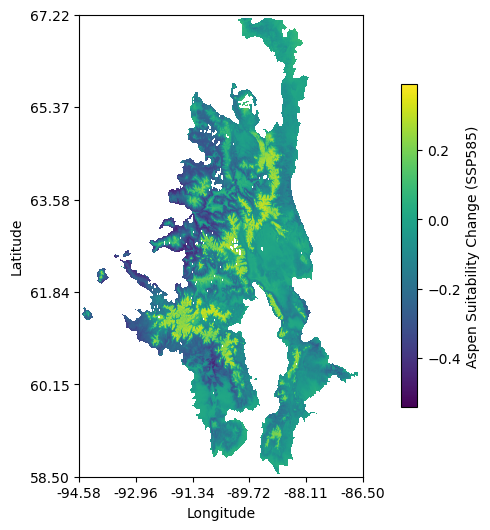

In [4]:
# load the future aspen suitability predictions
dir = os.path.join(projdir,'Aim3/data/spatial/raw/aspen_suitability/Predictions/')
# historical suitability
hist = os.path.join(dir,'predicted_historical_1981-2010_ensemble.tif')
# future suitability (SSP245 2041-2070)
ssp245 = os.path.join(dir,'predicted_SSP245_2041-2070_ensemble.tif')
# future suitability (SSP585 2041-2070)
ssp585 = os.path.join(dir,'predicted_SSP585_2041-2070_ensemble.tif')

# load each raster
hist_da = rxr.open_rasterio(hist, masked=True, cache=False).squeeze()
ssp245_da = rxr.open_rasterio(ssp245, masked=True, cache=False).squeeze()
ssp585_da = rxr.open_rasterio(ssp585, masked=True, cache=False).squeeze()

# calculate the change in suitability under both scenarios
change_SSP245 = ssp245_da - hist_da
change_SSP585 = ssp585_da - hist_da

# check the results
out_png = os.path.join(projdir, 'Aim3/figures/srm_aspen_suitability_change_ssp585.png')
plot_raster(change_SSP585, legend_lab = "Aspen Suitability Change (SSP585)", save_file=True, out_png=out_png)

In [5]:
change_SSP245.rio.crs

CRS.from_epsg(32613)

In [6]:
# calculate band statistics
# mean, standard deviation, percentiles

# create a list of rasters to calculate zonal stats
das = {
    'historic': hist_da, # historic (1981-2010) suitability
    'ssp245': ssp245_da, # raw suitability SSP245 2041-2070
    'ssp585': ssp585_da, # raw suitability SSP585 2041-2070
    'delta245': change_SSP245, # change SSP245 2041-2070
    'delta585': change_SSP585 # change SSP585 2041-2070
}

results = []
for key, da in das.items():
    print(f"Processing: {key}")
    # ensure the correct projection
    da_ = da.rio.reproject(proj) # matches grid
    # calculate zonal statistics
    zs = compute_band_stats(
        geoms=future_fire, 
        image_da=da_, 
        id_col='grid_id', 
        stats=['mean'], # 'median','std','percentile_90'
        attr=key,
        ztype='continuous'
    )
    results.append(zs)

# concatenate the results
future_aspen = pd.concat([df.set_index("grid_id") for df in results], axis=1).reset_index()
future_aspen.head()

Processing: historic
Processing: ssp245
Processing: ssp585
Processing: delta245
Processing: delta585


,grid_id,historic_mean,ssp245_mean,ssp585_mean,delta245_mean,delta585_mean
0,159230.0,0.077949,0.141750,0.188673,0.063800,0.110724
1,159231.0,0.079767,0.128937,0.173096,0.049170,0.093329
2,159232.0,0.095146,0.151842,0.198710,0.056696,0.103564
3,159233.0,0.138749,0.158245,0.199029,0.019496,0.060280
4,159234.0,0.212962,0.201934,0.235828,-0.011028,0.022866


In [7]:
del das, results, zs
gc.collect()

0

In [8]:
# rename the columns
future_aspen = future_aspen.rename(
    columns={
        'historic_mean': 'historic',
        'ssp245_mean': 'ssp245',
        'ssp585_mean': 'ssp585',
        'delta245_mean': 'delta245',
        'delta585_mean': 'delta585'
    }
)

# join to the fire dataframe
fire_fa = pd.merge(future_fire, future_aspen, on="grid_id", how="left")
fire_fa.head()

,grid_id,trend_area,trend_count,p_area,p_count,NA_L3NAME,US_L4NAME,US_L4CODE,geometry,historic,ssp245,ssp585,delta245,delta585
0,159230.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-861518.632 2246765.246, -858285.087...",0.077949,0.141750,0.188673,0.063800,0.110724
1,159231.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-858285.087 2246403.307, -855051.389...",0.079767,0.128937,0.173096,0.049170,0.093329
2,159232.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-855051.389 2246042.730, -851817.539...",0.095146,0.151842,0.198710,0.056696,0.103564
3,159233.0,301.282740,0.026862,1.926234e-07,1.677490e-09,Southern Rockies,Crystalline Mid-Elevation Forests,21c,"POLYGON ((-851817.539 2245683.513, -848583.540...",0.138749,0.158245,0.199029,0.019496,0.060280
4,159234.0,411.936265,0.034504,3.852110e-07,3.354837e-09,Southern Rockies,Crystalline Mid-Elevation Forests,21c,"POLYGON ((-848583.540 2245325.656, -845349.389...",0.212962,0.201934,0.235828,-0.011028,0.022866


Index(['grid_id', 'trend_area', 'trend_count', 'p_area', 'p_count',
       'NA_L3NAME', 'US_L4NAME', 'US_L4CODE', 'geometry', 'historic', 'ssp245',
       'ssp585', 'delta245', 'delta585', 'trend_count_sc', 'trend_area_sc',
       'delta245_sc', 'delta585_sc'],
      dtype='object')


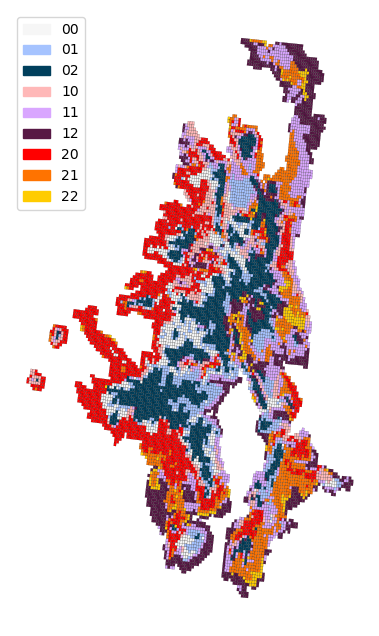

In [9]:
# Create a bivariate map of future fire/future aspen
df = fire_fa.copy() # work with a copy
# First, scale the variables for plotting
scaler = MinMaxScaler()
cols = ["trend_count", "trend_area", "delta245", "delta585"]
for col in cols:
    col_ = col+"_sc"
    df[col_] = scaler.fit_transform(df[[col]])
print(df.columns)
                                        
# Define class breaks (e.g., tertiles or quartiles)
df["fire_class"] = np.digitize(
    df["trend_count_sc"], 
    np.quantile(df["trend_count_sc"], [0.33, 0.67]))
df["aspen_class"] = np.digitize(
    df["delta585_sc"], 
    np.quantile(df["delta585_sc"], [0.33, 0.67]))

# Combine classifications to create bivariate classes
df["bivar"] = df["fire_class"].astype(str) + df["aspen_class"].astype(str)

# Define a custom bivariate colormap
bivar_colors = {
    "00": "#f6f6f6",  # Low fire, low aspen
    "01": "#a5c3ff",  # Low fire, medium aspen
    "02": "#003f5c",  # Low fire, high aspen
    "10": "#ffb8b8",  # Medium fire, low aspen
    "11": "#d9a6ff",  # Medium fire, medium aspen
    "12": "#581845",  # Medium fire, high aspen
    "20": "#ff0000",  # High fire, low aspen
    "21": "#ff7300",  # High fire, medium aspen
    "22": "#ffcc00",  # High fire, high aspen
}

# Assign colors based on the classification
df["color"] = df["bivar"].map(bivar_colors)

# Plot the bivariate map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
df.plot(
    ax=ax, 
    color=df["color"], 
    edgecolor="black", 
    linewidth=0.1)
# create the legend
legend_patches = [Patch(color=color, label=label) for label, color in bivar_colors.items()]
ax.legend(handles=legend_patches, title="", loc="upper left")
ax.axis("off")

plt.show()

In [10]:
# save this file out
out_fp = os.path.join(projdir, 'Aim3/data/spatial/mod/future_fire_grid_trend_aspen.gpkg')
fire_fa.to_file(out_fp)
print(f"Saved to: \n{out_fp}")

Saved to: 
/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim3/data/spatial/mod/future_fire_grid_trend_aspen.gpkg


In [11]:
# tidy up
del hist_da, ssp245_da, ssp585_da, change_SSP245, change_SSP585, future_aspen
gc.collect()

148

## Sentinel-based aspen cover (ca. 2019)

In [12]:
# load the 10-m aspen map (classification)
aspen10_fp = os.path.join(projdir,'Aim1/data/spatial/mod/results/classification/s2aspen_distribution_10m_y2019_CookEtAl.tif')
aspen10 = rxr.open_rasterio(aspen10_fp, cache=False, chunks='auto', mask=True).squeeze()
print(f"\n{aspen10}\n")
print(aspen10.rio.crs)


<xarray.DataArray (y: 95433, x: 64151)> Size: 6GB
dask.array<getitem, shape=(95433, 64151), dtype=uint8, chunksize=(2092, 64151), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 513kB -1.217e+06 -1.217e+06 ... -5.76e+05 -5.76e+05
  * y            (y) float64 763kB 2.309e+06 2.309e+06 ... 1.355e+06 1.355e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        1
    STATISTICS_MEAN:           0.015830995519141
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         0.1248213727693
    STATISTICS_VALID_PERCENT:  100
    _FillValue:                255
    scale_factor:              1.0
    add_offset:                0.0

EPSG:5070


In [13]:
t0 = time.time()

# calculate zonal statistics
aspen10_grids = compute_band_stats(
    geoms=future_fire, 
    image_da=aspen10, 
    id_col='grid_id', 
    attr='aspen10',
    ztype='categorical'
)
# only keep the count of aspen pixels
aspen10_grids = aspen10_grids[aspen10_grids['aspen10'] == 1]
# check the results
print(aspen10_grids.head())

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.\n")
print("\n~~~~~~~~~~\n")

    grid_id  aspen10  count  total_pixels  pct_cover
1  159230.0        1      8        146335   0.005467
3  159231.0        1     23        146342   0.015717
5  159232.0        1    764        146346   0.522050
7  159233.0        1    100        146336   0.068336
9  159234.0        1    369        146336   0.252159

Total elapsed time: 0.66 minutes.


~~~~~~~~~~



In [14]:
aspen10_grids['pct_cover'].describe()

count    9212.000000
mean        6.760243
std        11.574808
min         0.000617
25%         0.204016
50%         1.432681
75%         7.450748
max        80.162397
Name: pct_cover, dtype: float64

In [15]:
# rename for clarity
aspen10_grids.rename(columns={
    'pct_cover': 'aspen10_pct',
    'count': 'aspen10_pixn'
}, inplace=True)

# merge back to the main grid data
fire_fa_ = pd.merge(fire_fa, aspen10_grids[['grid_id','aspen10_pct','aspen10_pixn']], on='grid_id')
fire_fa_.columns

Index(['grid_id', 'trend_area', 'trend_count', 'p_area', 'p_count',
       'NA_L3NAME', 'US_L4NAME', 'US_L4CODE', 'geometry', 'historic', 'ssp245',
       'ssp585', 'delta245', 'delta585', 'aspen10_pct', 'aspen10_pixn'],
      dtype='object')

In [16]:
del aspen10, aspen10_grids, fire_fa
gc.collect() # free memory

441

## Built Environment Summaries

COMBUST, Microsoft Building Footprints, WorldPop population density/counts, and WUI classification (10-m)

In [17]:
# Contemporary COMBUST grid (combustible mass of the built environment)
combust_fp = os.path.join(projdir,'Aim3/data/spatial/raw/COMBUST/combustible_building_mass_t_2020_mean.tif')
# Miscrosoft building footprint counts (same grid as COMBUST)
msbf_fp = os.path.join(maindir,'earth-lab/opp-urban-fuels/data/spatial/mod/Microsoft/msbf_counts.tif')
# WorldPop population density estimates
wp_density_fp = os.path.join(projdir,'Aim3/data/spatial/raw/WorldPop/usa_pd_2020_1km.tif')
wp_count_fp = os.path.join(projdir,'Aim3/data/spatial/raw/WorldPop/srm_ppp_2020_constrained.tif')

# put the continuous rasters in a dictionary to calculate zonal stats
das = {
    'combust': combust_fp,
    'msbf_count': msbf_fp,
    'pop_density': wp_density_fp,
    'pop_count': wp_count_fp,
}

results = []
# map the dictionary, calculate zonal stats
for key, fp in das.items():
    print(f"Processing: {key}")
    # process the raster grid
    da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
    da = da.rio.reproject(proj) # ensure matching projection
    if key == 'pop_density':
        stat = ['mean']
    else:
        stat = ['sum']
    # calculate zonal statistics
    zs = compute_band_stats(
        geoms=future_fire, 
        image_da=da, 
        id_col='grid_id', 
        stats=stat, 
        attr=key,
        ztype='continuous'
    )
    results.append(zs)
    del da, zs
    
# concatenate the results
built_env_pop = pd.concat([df.set_index("grid_id") for df in results], axis=1).reset_index()
built_env_pop.head()

Processing: combust
Processing: msbf_count
Processing: pop_density
Processing: pop_count


,grid_id,combust_sum,msbf_count_sum,pop_density_mean,pop_count_sum
0,159230.0,866.741028,40.0,1.012462,NaN
1,159231.0,2105.277588,84.0,5.431233,21.508411
2,159232.0,6195.236816,247.0,16.635210,193.112381
3,159233.0,1774.940186,96.0,4.073417,NaN
4,159234.0,3126.656250,141.0,8.421898,NaN


In [18]:
# calculate the zonal stats for the WUI classes
# load the SILVIS Lab 10-m WUI classification
fp = os.path.join(projdir, 'Aim3/data/spatial/raw/silvis/srm_wui_silvis_10m_buffer.tif')
wui = rxr.open_rasterio(fp, masked=True, chunks='auto').squeeze()
print(wui)

<xarray.DataArray (y: 103813, x: 71231)> Size: 30GB
[7394703803 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 570kB -1.287e+06 -1.287e+06 ... -5.842e+05
  * y            (y) float64 831kB 2.353e+06 2.353e+06 ... 1.297e+06 1.297e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        8
    STATISTICS_MEAN:           5.7932122202733
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         1.1546511369916
    STATISTICS_VALID_PERCENT:  98.49
    scale_factor:              1.0
    add_offset:                0.0


In [ ]:
# # calculate "distance to nearest WUI"
# wui_bin = xr.where(np.isin(wui, [1, 2, 3, 4]), 1, 0)
# wui_bin.values.unique()
# # # Compute Euclidean distance transform
# # distance_to_wui = xr.apply_ufunc(
# #     distance_transform_edt,
# #     1 - wui_bin
# # )
# # plot_raster(distance_to_wui)

In [19]:
# calculate the percent cover of WUI classes for each grid
t0 = time.time()

# see __functions.py
wui_grid = compute_band_stats(future_fire, wui, 'grid_id', attr='wui')
# tidy columns in the summary table
wui_grid['count'] = wui_grid['count'].astype(int)
wui_grid['total_pixels'] = wui_grid['total_pixels'].astype(int)
wui_grid.rename(columns = {'count': 'wui_pixels'}, inplace=True)

print(wui_grid.head())

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del wui # clean up 
gc.collect()

NameError: name 'wui' is not defined

In [ ]:
wui_grid['wui'].unique()

In [ ]:
# join the WUI description
# create the mappings
wui_desc = {
    0: 'No Data',
    1: 'Forest/Shrubland/Wetland-dominated Intermix WU',
    2: 'Forest/Shrubland/Wetland-dominated Interface WUI',
    3: 'Grassland-dominated Intermix WUI',
    4: 'Grassland -dominated Interface WUI',
    5: 'Non-WUI: Forest/Shrub/Wetland-dominated',
    6: 'Non-WUI: Grassland-dominated',
    7: 'Non-WUI: Urban',
    8: 'Non-WUI: Other'
}

# join back to the results
wui_grid['wui_desc'] = wui_grid['wui'].map(wui_desc)
wui_grid.head()

In [ ]:
# pivot the table to get WUI percent cover
wui_w = wui_grid.pivot_table(index='grid_id', columns='wui', values='pct_cover', fill_value=0)
wui_w = wui_w[[1, 2, 3, 4]] # keep only WUI classes
wui_w.columns = [f"wui{int(col)}" for col in wui_w.columns] # rename the columns
wui_w = wui_w.reset_index()
wui_w.head()

In [ ]:
# merge WUI/built environment
wui_blt = pd.merge(wui_w, built_env_pop, on='grid_id', how='left')
# merge back to the main grid data
fire_fa_blt = pd.merge(fire_fa_, wui_blt, on='grid_id', how='left')
fire_fa_blt.columns

## Contemporary Fire Activity and Fire Risk 

### Ignition Causes

In [ ]:
# load the fpa-fod ignitions data and get the total count
fpa_fp = os.path.join(projdir,'Aim3/data/spatial/mod/fire/srm_fpa_fod.gpkg')
fpa = gpd.read_file(fpa_fp)
fpa.columns

In [ ]:
print(fpa['FIRE_YEAR'].min())
print(fpa['FIRE_YEAR'].max())

In [ ]:
# load the ICS (for 2021-2023)

In [ ]:
fpa['NWCG_CAUSE_CLASSIFICATION'].unique()

In [ ]:
# calculate the area burned by ignition cause
cause_burned = (
    fpa.groupby('NWCG_CAUSE_CLASSIFICATION', as_index=False)
    .agg(
        area_burned=('FIRE_SIZE','sum'),
        fire_count=('OBJECTID', 'count')   
    )
)
# rename the cause column
cause_burned.rename(columns={'NWCG_CAUSE_CLASSIFICATION': 'cause'}, inplace=True)
# replace the undetermined code
cause_burned['cause'] = cause_burned['cause'].replace(
    "Missing data/not specified/undetermined", "Undetermined"
)
# check the results
cause_burned.head()

In [ ]:
# Define labels and values for both metrics
labels = cause_burned['cause']
sizes_area = cause_burned['area_burned']
sizes_count = cause_burned['fire_count']

# define color mapping
color_map = {
    "Human": "#B22222",        
    "Natural": "#377EB8",      
    "Undetermined": "#B3B3B3"  
}
# map the colors
colors = [color_map.get(cause, "#CCCCCC") for cause in cause_burned["cause"]]

# Create subplots for two pie charts
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].pie(sizes_area, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
axes[0].text(-1.3, 1.1, "A", fontsize=11, fontweight="bold")  # Add subplot label "A"
axes[1].pie(sizes_count, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
axes[1].text(-1.3, 1.1, "B", fontsize=11, fontweight="bold")  # Add subplot label "B"

# Show plot
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'Aim3/figures/FPA-FOD_cause_pie.png'), dpi=300, bbox_inches='tight')

plt.show()

### Burned Area

In [ ]:
# load burned area and calculate the cumulative area burned
mtbs_fp = os.path.join(projdir,'Aim3/data/spatial/mod/fire/srm_mtbs_perims_dd.gpkg')
mtbs = gpd.read_file(mtbs_fp)
mtbs.columns

In [ ]:
mtbs['Ig_Date'] = pd.to_datetime(mtbs['Ig_Date'])
mtbs['Fire_Year'] = mtbs['Ig_Date'].dt.year
mtbs[['Ig_Date','Fire_Year']].head()

In [ ]:
print(mtbs['Fire_Year'].min())
print(mtbs['Fire_Year'].max())

In [ ]:
# plot the annual area burned
burned_area = mtbs.groupby('Fire_Year')['BurnBndAc'].sum().reset_index()

# Function to format colorbar labels with 'k' notation
def format_ticks(value, _):
    return f'{int(value / 1000)}k'

formatter = FuncFormatter(format_ticks)

# Plot the results
plt.figure(figsize=(7, 3))
plt.bar(burned_area['Fire_Year'], burned_area['BurnBndAc'], color='grey', edgecolor='black')
plt.xlabel('Year', fontsize=10)
plt.ylabel('Area Burned (ha)', fontsize=9)
plt.xticks(burned_area['Fire_Year'], rotation=45, size=8)

# Apply custom formatting to y-axis
plt.gca().yaxis.set_major_formatter(formatter)
# plt.ylim(10000, None)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'Aim3/figures/MTBS_annualBurnedArea.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# calculate the cumulative previous area burned
mtbs = mtbs.to_crs(proj) # ensure the correct CRS
mtbs_in_grid = gpd.overlay(mtbs, future_fire, how='intersection') # perform the overlay
# get the cumulative burned area in each grid cell
mtbs_in_grid['burned_area'] = mtbs_in_grid.geometry.area
burned_area_c = mtbs_in_grid.groupby('grid_id', as_index=False)['burned_area'].sum()
# calculate the cumulative percent burned
# get the gridcell area
future_fire['grid_area'] = future_fire.geometry.area


# merge burned area summary back to grid cells
future_fire_ = future_fire.merge(burned_area_c, on='grid_id', how='left')
# fill NaN values (for grid cells with no fire) with 0
future_fire_['burned_area'] = future_fire_['burned_area'].fillna(0)
# Compute percentage of each grid cell burned
future_fire_['burned_pct'] = (future_fire_['burned_area'] / future_fire_['grid_area']) * 100
future_fire_ = future_fire_[['grid_id','burned_area','burned_pct']]
print(future_fire_.head())

# merge back to the main grid data
fire_fa_blt_ba = pd.merge(fire_fa_blt, future_fire_, on='grid_id', how='left')
fire_fa_blt_ba.columns

### Wildfire Hazard Potential (version 2023)

In [ ]:
# load the wildfire hazard potential
fp = os.path.join(projdir,'Aim3/data/spatial/raw/fsim/Data/whp2023_GeoTIF/whp2023_cnt_conus.tif')
whp = rxr.open_rasterio(fp, masked=True, chunks='auto').squeeze()
whp = whp.rio.reproject(proj) # matches grid
# calculate the zonal stats
whp_zs = compute_band_stats(
    geoms=future_fire, 
    image_da=whp, 
    id_col='grid_id', 
    stats=['percentile_90'], # 'median','std','percentile_90'
    attr='whp',
    ztype='continuous'
)
za.head()

In [ ]:
# merge back to the main grid data
fire_fa_blt_ba_ = pd.merge(fire_fa_blt_ba, whp_zs, on='grid_id', how='left')
fire_fa_blt_ba_.columns

## USFS TreeMap Summaries
### FORTYPCD

In [45]:
# Load the TreeMap (ca. 2016)
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "Aim2/data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
tmid_da = treemap_da.sel(band=1) # the tm_id band
fortyp_da = treemap_da.sel(band=2) # the fortypcd band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = fortyp_da.shape, fortyp_da.spatial_ref.GeoTransform, fortyp_da.rio.crs, fortyp_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {fortyp_da[0].dtype}")

del treemap_da # clean up
gc.collect()

Shape: (28724, 17006); 
GeoTransform: -1193295.0 30.0 0.0 2253345.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


43

In [52]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(fortyp_da), 1, 0)
# calculate the grid-level forest percent
forest_pct = compute_band_stats(future_fire, forest_mask, 'grid_id', attr='forest')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
print(forest_pct.head())
# gather the forest percent
forest_pct = forest_pct[forest_pct['forest'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_id','forest_pixels','forest_pct']]
# how many forested grids are there? (>50%)
n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(future_fire)*100,2)}%] predominantly forest grids.")
print(f"\n{forest_pct.head(3)}")
# tidy up
del forest_mask
gc.collect() # clean up

    grid_id  forest  count  forest_pixels  forest_pct
0  159230.0       0  16308          16450   99.136778
1  159230.0       1    142          16450    0.863222
2  159231.0       0  14784          16455   89.845032
3  159231.0       1   1671          16455   10.154968
4  159232.0       0  14316          16453   87.011487

[65.24%] predominantly forest grids.

    grid_id  forest_pixels  forest_pct
1  159230.0          16450    0.863222
3  159231.0          16455   10.154968
5  159232.0          16453   12.988513


15

In [53]:
# calculate forest type percent from the FORTYPCD
t0 = time.time()

df = future_fire[['grid_id','geometry']]

# see __functions.py
fire_fa_fortyp = compute_band_stats(df, fortyp_da, 'grid_id', attr='fortypcd')
# tidy columns in the summary table
fire_fa_fortyp['count'] = fire_fa_fortyp['count'].astype(int)
fire_fa_fortyp['total_pixels'] = fire_fa_fortyp['total_pixels'].astype(int)
fire_fa_fortyp.rename(columns = {'count': 'fortyp_pixels'}, inplace=True)

# load the species lookup table
fp = os.path.join(projdir,'Aim2/data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df.rename(columns={
    'FORTYPCD': 'fortypcd',
    'SpeciesName': 'fortypnm'
}, inplace=True)

# join the forest name
fire_fa_fortyp = fire_fa_fortyp.merge(species_df, on='fortypcd', how='left')
print(f"\n{fire_fa_fortyp.head(3)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del fortyp_da, species_df # clean up 
gc.collect()


    grid_id  fortypcd  fortyp_pixels  total_pixels  pct_cover  \
0  159230.0       182             70           142  49.295775   
1  159230.0       184             50           142  35.211268   
2  159230.0       221             20           142  14.084507   

                 fortypnm  
0  Rocky Mountain juniper  
1        Juniper woodland  
2          Ponderosa pine  

Total elapsed time: 0.25 minutes.

~~~~~~~~~~



0

In [54]:
fire_fa_fortyp['fortypnm'].unique()

array(['Rocky Mountain juniper', 'Juniper woodland', 'Ponderosa pine',
       'Cottonwood', 'Nonstocked', 'Pinyon / juniper woodland',
       'Sugarberry / hackberry / elm / green ash', 'Douglas-fir',
       'Western juniper', 'White fir', 'Lodgepole pine', 'Limber pine',
       'Aspen', 'Deciduous oak woodland', 'White spruce', 'Grand fir',
       'Subalpine fir', 'Western larch', 'California mixed conifer',
       'Balsam fir', 'Engelmann spruce / subalpine fir', 'Bur oak',
       'Elm / ash / black locust', 'Paper birch', 'Other hardwoods',
       'Cercocarpus (mountain brush) woodland', 'Engelmann spruce',
       'Blue spruce', 'Foxtail pine / bristlecone pine', 'Pin cherry',
       'Sugar maple / beech / yellow birch',
       'Intermountain maple woodland', 'Cottonwood / willow',
       'Miscellaneous woodland hardwoods', 'Jeffrey pine',
       'Red maple / upland', 'Black ash / American elm / red maple',
       'Miscellaneous western softwoods', 'Evergreen oak woodland',
       '

In [57]:
# subset to southern rockies forest types
fortyp_srm = [
    'Rocky Mountain juniper', 'Juniper woodland', 'Pinyon / juniper woodland', 'Douglas-fir', 'Ponderosa pine',
    'White fir', 'Engelmann spruce', 'Cottonwood', 'Aspen', 'Deciduous oak woodland', 'Lodgepole pine', 
    'Willow', 'Cercocarpus (mountain brush) woodland', 'Engelmann spruce / subalpine fir', 'Subalpine fir', 
    'Foxtail pine / bristlecone pine', 'Limber pine', 'Cottonwood / willow', 'Blue spruce', 'Evergreen oak woodland', 
    'Mixed upland hardwoods'
]

# subset the dataframe
fire_fa_fortyp = fire_fa_fortyp[fire_fa_fortyp['fortypnm'].isin(fortyp_srm)]

# Aggregate into forest groups
spp_grouping = {
    'pinyon|juniper': 'Piñon-juniper',
    'spruce|subalpine': 'Spruce-fir',
    'ponderosa pine': 'Ponderosa pine', 
    'lodgepole pine': 'Lodgepole pine', 
    'aspen': 'Quaking aspen',
    'douglas-fir': 'Douglas-fir',
    'white fir': 'White fir',
    'deciduous oak woodland': 'Oak woodland',
    'cottonwood|willow': 'Riparian woodland'
}

# create the remap table
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = fire_fa_fortyp[fire_fa_fortyp['fortypnm'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update(
        {name: spp_group for name in spp['fortypnm'].unique()}
    )
    del spp
    
# Apply the remap to create a new grouped species column
fire_fa_fortyp['fortypnm_gp'] = fire_fa_fortyp['fortypnm'].map(spp_remap).fillna(fire_fa_fortyp['fortypnm'])
# Verify the updated species groups
print(fire_fa_fortyp[['fortypnm', 'fortypnm_gp']].drop_duplicates().head(3))
print(f"\n{fire_fa_fortyp.columns}")

                 fortypnm     fortypnm_gp
0  Rocky Mountain juniper   Piñon-juniper
1        Juniper woodland   Piñon-juniper
2          Ponderosa pine  Ponderosa pine

Index(['grid_id', 'fortypcd', 'fortyp_pixels', 'total_pixels', 'pct_cover',
       'fortypnm', 'fortypnm_gp'],
      dtype='object')


In [58]:
# Aggregate with the new species groupings
# Reacalculate the percent cover for each species group
fire_fa_fortypgp = (
    fire_fa_fortyp.groupby(['grid_id','fortypnm_gp'], as_index=False)
    .agg(
        fortyp_pixels=('fortyp_pixels','sum'),
        total_pixels=('total_pixels','max'),
        fortyp_pct=('pct_cover','sum'),
    )
)

# Merge in the forest percent
fire_fa_fortypgp = fire_fa_fortypgp.merge(forest_pct, on='grid_id', how='inner')

# Check on nulls introduced
print(f"\nNaNs in FORTYP group name: {fire_fa_fortypgp['fortypnm_gp'].isna().sum()}\n")
print(f"\n{fire_fa_fortypgp.head(10)}\n")
print(f"Forest percent:\n{fire_fa_fortypgp['forest_pct'].describe()}\n")
print("\n~~~~~~~~~~~~~~~~~~\n")

gc.collect()


NaNs in FORTYP group name: 0


    grid_id        fortypnm_gp  fortyp_pixels  total_pixels  fortyp_pct  \
0  159230.0      Piñon-juniper            120           142   84.507042   
1  159230.0     Ponderosa pine             20           142   14.084507   
2  159230.0  Riparian woodland              1           142    0.704225   
3  159231.0      Piñon-juniper           1121          1671   67.085577   
4  159231.0     Ponderosa pine            109          1671    6.523040   
5  159231.0  Riparian woodland             17          1671    1.017355   
6  159232.0        Douglas-fir              3          2137    0.140384   
7  159232.0      Piñon-juniper           1685          2137   78.848854   
8  159232.0     Ponderosa pine            163          2137    7.627515   
9  159232.0  Riparian woodland            123          2137    5.755732   

   forest_pixels  forest_pct  
0          16450    0.863222  
1          16450    0.863222  
2          16450    0.863222  
3          16455  

72



Species making up 99% of the total: 

       fortypnm_gp  fortyp_pixels  fraction  c_fraction
12      Spruce-fir       23427657  0.228321    0.228321
9   Ponderosa pine       19780728  0.192779    0.421100
8    Piñon-juniper       18954481  0.184727    0.605827
10   Quaking aspen       16746486  0.163208    0.769035
5   Lodgepole pine       12746987  0.124230    0.893265
1      Douglas-fir        5897885  0.057480    0.950744
7     Oak woodland        2305533  0.022469    0.973213
13       White fir        1623848  0.015826    0.989039




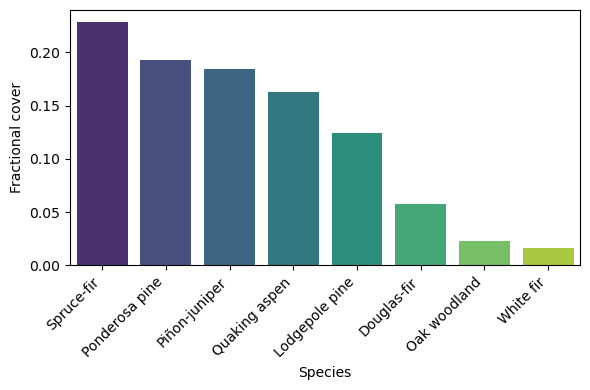

186

In [59]:
# Create a histogram of the forest species (prevalence)
fortyp = fire_fa_fortypgp.copy() # make a copy to work with
fortyp = fortyp[fortyp['fortyp_pixels'] > 0] # make sure there are some pixels

# calculate the landscape fraction (prevalence)
spp_pr = fortyp.groupby('fortypnm_gp')['fortyp_pixels'].sum().reset_index()
spp_pr['fraction'] = spp_pr['fortyp_pixels'] / spp_pr['fortyp_pixels'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)
# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.99]
print(f"\n\nSpecies making up 99% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='fortypnm_gp', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# clean up
del fortyp, spp_pr
gc.collect()

In [66]:
fire_fa_fortypgp[fire_fa_fortypgp['grid_id'] == 159235.0].head()

,grid_id,fortypnm_gp,fortyp_pixels,total_pixels,fortyp_pct,forest_pixels,forest_pct
28,159235.0,douglas-fir,276,4642,5.945713,16449,28.220561
29,159235.0,lodgepole pine,103,4642,2.218871,16449,28.220561
30,159235.0,oak woodland,33,4642,0.710900,16449,28.220561
31,159235.0,piñon-juniper,98,4642,2.111159,16449,28.220561
32,159235.0,ponderosa pine,3843,4642,82.787592,16449,28.220561


In [68]:
# gather the top three most dominant forest types

def dom_spps(df):
    top_three = df.nlargest(3, 'fortyp_pct')  # Get top three by percent cover
    return pd.Series({
        'dom_spp1': top_three.iloc[0]['fortypnm_gp'] if len(top_three) > 0 else None,
        'dom_spp2': top_three.iloc[1]['fortypnm_gp'] if len(top_three) > 1 else None,
        'dom_spp3': top_three.iloc[2]['fortypnm_gp'] if len(top_three) > 2 else None
    })

# Apply function per grid_id
dom_fortyps = fire_fa_fortypgp.groupby('grid_id').apply(dom_spps).reset_index()
dom_fortyps.head(10)

,grid_id,dom_spp1,dom_spp2,dom_spp3
0,159230.0,piñon-juniper,ponderosa pine,riparian woodland
1,159231.0,piñon-juniper,ponderosa pine,riparian woodland
2,159232.0,piñon-juniper,ponderosa pine,riparian woodland
3,159233.0,piñon-juniper,ponderosa pine,oak woodland
4,159234.0,ponderosa pine,quaking aspen,piñon-juniper
5,159235.0,ponderosa pine,douglas-fir,quaking aspen
6,159236.0,ponderosa pine,douglas-fir,piñon-juniper
7,159237.0,ponderosa pine,douglas-fir,lodgepole pine
8,159238.0,ponderosa pine,douglas-fir,lodgepole pine
9,159239.0,ponderosa pine,douglas-fir,lodgepole pine


In [71]:
# Load the TreeMap Canopy % 
canopypct = os.path.join(projdir, "Aim2/data/spatial/raw/USFS/TreeMap/treemap_west_canopypct.tif") 
canopypct = rxr.open_rasterio(canopypct, mask=True, chunks='auto').squeeze()
# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = canopypct.shape, canopypct.spatial_ref.GeoTransform, canopypct.rio.crs, canopypct.rio.nodata
print(
    f"\nShape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {canopypct[0].dtype}\n")

# Calculate the mean grid-level canopy percent
canopypct_zs = compute_band_stats(
    geoms=future_fire, 
    image_da=canopypct, 
    id_col='grid_id', 
    attr='canopypct', 
    stats=['mean'], 
    ztype='continuous'
)
del canopypct
canopypct_zs.head()


Shape: (72854, 61899); 
GeoTransform: -2361585.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: -128; 
Data Type: int8



,grid_id,canopypct_mean
0,159230.0,16.697183
1,159231.0,17.373429
2,159232.0,22.065512
3,159233.0,22.022885
4,159234.0,28.771429


In [73]:
# Load the TreeMap BALIVE
balive = os.path.join(projdir, "Aim2/data/spatial/raw/USFS/TreeMap/treemap_west_balive.tif") 
balive = rxr.open_rasterio(balive, masked=True, chunks='auto').squeeze()
# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = balive.shape, balive.spatial_ref.GeoTransform, balive.rio.crs, balive.rio.nodata
print(
    f"\nShape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {balive[0].dtype}\n")

# Calculate the mean grid-level canopy percent
balive_sum = compute_band_stats(
    geoms=future_fire, 
    image_da=balive, 
    id_col='grid_id', 
    attr='balive', 
    stats=['sum'],
    ztype='continuous'
)

del balive

# Merge the canopy percent and BALIVE
grid_metrics = pd.merge(canopypct_zs, balive_sum, on="grid_id", how="inner")
print(grid_metrics.head())

del canopypct_zs, balive_sum
gc.collect()


Shape: (72854, 61899); 
GeoTransform: -2361585.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32

    grid_id  canopypct_mean     balive_sum
0  159230.0       16.697183    4540.965820
1  159231.0       17.373429   66424.570312
2  159232.0       22.065512  116070.382812
3  159233.0       22.022885  191579.750000
4  159234.0       28.771429  238625.250000


1083

In [82]:
# merge treemap data
tm_df = pd.merge(dom_fortyps, grid_metrics, on='grid_id', how='left')
tm_df.head()

,grid_id,dom_spp1,dom_spp2,dom_spp3,canopypct_mean,balive_sum
0,159230.0,piñon-juniper,ponderosa pine,riparian woodland,16.697183,4540.965820
1,159231.0,piñon-juniper,ponderosa pine,riparian woodland,17.373429,66424.570312
2,159232.0,piñon-juniper,ponderosa pine,riparian woodland,22.065512,116070.382812
3,159233.0,piñon-juniper,ponderosa pine,oak woodland,22.022885,191579.750000
4,159234.0,ponderosa pine,quaking aspen,piñon-juniper,28.771429,238625.250000


In [83]:
# merge back to the main grid data
fire_fa_blt_ba_tm = pd.merge(fire_fa_blt_ba_, tm_df, on='grid_id', how='left')
fire_fa_blt_ba_tm.columns

Index(['grid_id', 'trend_area', 'trend_count', 'p_area', 'p_count',
       'NA_L3NAME', 'US_L4NAME', 'US_L4CODE', 'geometry', 'historic', 'ssp245',
       'ssp585', 'delta245', 'delta585', 'aspen10_pct', 'aspen10_pixn', 'wui1',
       'wui2', 'wui3', 'wui4', 'combust_sum', 'msbf_count_sum',
       'pop_density_mean', 'pop_count_sum', 'burned_area', 'burned_pct',
       'iFLP6_p90', 'iFLP5_p90', 'iFLP4_p90', 'iBP_p90', 'iFLP1_p90',
       'iFLP3_p90', 'iFLP2_p90', 'dom_spp1', 'dom_spp2', 'dom_spp3',
       'canopypct_mean', 'balive_sum'],
      dtype='object')

In [84]:
# save this data out
out_fp = os.path.join(projdir, 'Aim3/data/spatial/mod/srm_model_data.gpkg')
fire_fa_blt_ba_tm.to_file(out_fp)
print(f"\nSaved to: {out_fp}\n")


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim3/data/spatial/mod/srm_model_data.gpkg

